I wanted to make a real fast implementation of Fourier Series to show myself that I understand it:

Here's how I put it to myself:

<i> "The Fourier Series expansion of a continuosu function $f: [a, b] \to \mathbb{C}$ is simply the decomposition of $f$ into a linear combination of orthonormal components in the space to which this function naturally belongs, i.e. in the space of continuous complex-valued functions over $[a, b]$, with natural inner product $<f, g> = \int^a_b f(x)\overline{g(x)} dx$"<i>
    
In particular, Fourier Series considers the orthogonal sequence that "spans"* the space $e^{ikx} = cos(kx) + isin(kx)$ for $k \in \mathbb{Z}$. (Notice that $<e^{ikx}, e^{ilx}>$ is equal to $0$ $\forall l \neq k$ and is equal to $2\pi$ when $k=l$). Hence... to make the sequence orthonormal (and so to satisfy parseval's identity and exactly correspond to the above statement... the <b>orthonormal</b> basis Fourier Series uses is $\frac{1}{2\pi} e^{ikx}$

i.e. $f(x) = \sum_{k = -\infty}^{\infty} <f, e^{ikx}>e^{ikx}$ where $<f, g> = \int^a_b f(x)\overline{g(x)} dx$"<i>

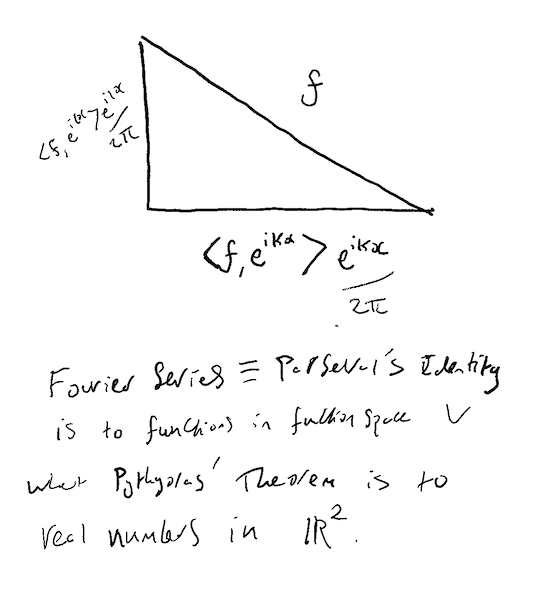



*(for what I mean by spans in terms of an infinite dimensional vector space, see: https://math.stackexchange.com/questions/86762/finding-a-basis-of-an-infinite-dimensional-vector-space) 

<b>Note:</b> I _think_ this intuition can be used to prove that $e^{ikx}$ is an orthonormal "infinite basis" of such a function space.

Also note: I'm only considering $a = -\pi, b=\pi$ for now. This can easily be extended to the general case.

This allows us to approximate functions that are continuous on an interval with the fourier series expansion over that interval! (Note that if the function is periodic over the interval, then this is equivalent to approximating the function everywhere!)

Let's actually write some code and do an approximation:

In [1]:
import numpy as np

In [2]:
import scipy
from scipy.integrate import quad

First note that we'll be using scipy's `integrate.quad` function to do our numerical integration. It's really simple - quad simply returns a tuple of the integral as well as an estimate of the absolute error (this last term is useful for knowing when there's a problem with our numerical integration, and not with the code we've written!)

In [3]:
quad(lambda x: x, 0, 1)

(0.5, 5.551115123125783e-15)

However, to keep things general, I'm sticking with the definition of the function spaces containing complex valued functions. Luckily these functions are real-argumented, so we don't have to do contour integration... we can just separate the integrand into real and imaginary (I THINK!)... (I'll move into the purely Real case later at some point, since the mathematics considers the subspace) 

but for now... use:

In [4]:
def complex_quad(func, a, b, **kwargs):
    def real_func(x):
        return scipy.real(func(x))
    def imag_func(x):
        return scipy.imag(func(x))
    real_integral = quad(real_func, a, b, **kwargs)
    imag_integral = quad(imag_func, a, b, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1], imag_integral[1])

In [5]:
# we'll define a function space class that computes the inner product of a function
# let's also restrict ourselves to the real case for now... in which the conjugate of g is equal to g.
# but the space is a subspace of the space of complex continuos functions... so we shouldn't have to change
# much else!

class FunctionSpace:
    
    # default interval is (-pi, pi) since that's where the e^ikx is basis function for.
    def __init__(self, interval=(-np.pi, np.pi)):
        self.interval = interval
        self.a = interval[0]
        self.b = interval[1]
        
    def inner_product(self, f, g):
        return complex_quad(lambda x: f(x)*np.conj(g(x)), self.a, self.b)[0]
    
    def basis_func(self, k):
        return lambda x: np.complex(np.cos(k*x), np.sin(k*x))
        

In [6]:
class FourierSeries():
    
    def __init__(self, f, function_space, k=100):
        # f should be a member of the function space (continuous and square integrable over its interval!)
        self.basis_range = list(range(-(k//2), (k//2) + 1))
        
        self.basis_funcs = []
        for k in self.basis_range:
            self.basis_funcs.append(function_space.basis_func(k))
            
        # calculate coefficients
        self.coeffs = self._get_k_coefficients(f, function_space)
        
    def _get_k_coefficients(self, f, function_space):
        coeffs = []
        
        # why do we need to iterate over equal parts negative and positive k here... I don't know? Think about it!
        for basis_func in self.basis_funcs:
            inner_product = function_space.inner_product(f, basis_func)
            coeffs.append(inner_product)
            
        return coeffs
        
    def __call__(self, x):
        #print(self.basis_funcs)
        evaluated_basis_funcs = list(map(lambda f: f(x), self.basis_funcs))
        return (np.array(self.coeffs).dot(np.array(evaluated_basis_funcs)))/(2*np.pi)


In [7]:
real_f = lambda x: x**3
target_f = lambda x: complex(real_f(x), 0)

k = 1000
fseries = FourierSeries(target_f, FunctionSpace(), k=100)

In [8]:
from IPython.core.pylabtools import figsize
figsize(16, 10)

import matplotlib.pyplot as plt
xs = np.linspace(-1, 1, 1000)
f_xs = np.real(np.vectorize(target_f)(xs))
series_xs = np.real(np.vectorize(fseries.__call__)(xs))

plt.plot(xs, f_xs)

# fix why am i adding this minus?
plt.plot(xs, series_xs)
plt.show()

<Figure size 1600x1000 with 1 Axes>

<b>Really cool thing: the same idea can probably (definitely) be used in other function spaces... </b>

Sing with me: ooohhhhh, you just gotta decompose into orthonormal components!